# MCMC Orbit

In [26]:
import jax

jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp

import astropy.units as u
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astropy.time import Time
from astroquery.jplhorizons import Horizons

import emcee
from corner import corner

from jorbit import Particle, Observations
from jorbit.data.constants import SPEED_OF_LIGHT
from jorbit.utils.states import KeplerianState, CartesianState

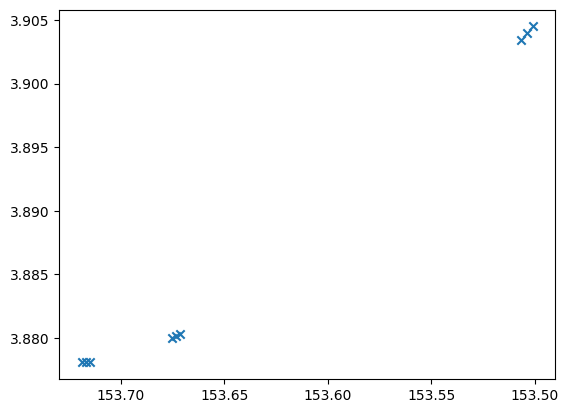

In [27]:
nights = [Time("2025-01-01 07:00"), Time("2025-01-02 07:00"), Time("2025-01-05 07:00")]

times = []
for n in nights:
    times.extend([n + i * 1 * u.hour for i in range(3)])
times = Time(times)

obj = Horizons(id="274301", location="695@399", epochs=times.utc.jd)
pts = obj.ephemerides(extra_precision=True, quantities="1")

coords = SkyCoord(pts["RA"], pts["DEC"], unit=(u.deg, u.deg))
times = Time(pts["datetime_jd"], format="jd", scale="utc")

fig, ax = plt.subplots()
ax.scatter(coords.ra.deg, coords.dec.deg, marker="x")
ax.invert_xaxis()

obs = Observations(
    observed_coordinates=coords,
    times=times,
    observatories="kitt peak",
    astrometric_uncertainties=1 * u.arcsec,
)

ti = times[0] - 1 * u.hour
wiki = Particle.from_horizons("274301", time=ti, observations=obs)

In [28]:
@jax.jit
def loglike(elements_vec):
    state = KeplerianState(
        semi=jnp.array([elements_vec[0]]),
        ecc=jnp.array([elements_vec[1]]),
        nu=jnp.array([elements_vec[2]]),
        inc=jnp.array([elements_vec[3]]),
        Omega=jnp.array([elements_vec[4]]),
        omega=jnp.array([elements_vec[5]]),
        acceleration_func_kwargs={},
        time=ti.tdb.jd,
    )
    resids = wiki.static_residuals(state)

    quad = jnp.einsum(
        "bi,bij,bj->b", resids, wiki.observations.inv_cov_matrices, resids
    )

    ll = jnp.sum(
        -0.5 * (2 * jnp.log(2 * jnp.pi) + wiki.observations.cov_log_dets + quad)
    )
    return ll


x0 = jnp.squeeze(
    jnp.array(
        [
            wiki.keplerian_state.semi,
            wiki.keplerian_state.ecc,
            wiki.keplerian_state.nu,
            wiki.keplerian_state.inc,
            wiki.keplerian_state.Omega,
            wiki.keplerian_state.omega,
        ]
    )
)
loglike(x0)

Array(-16.5408936, dtype=float64)

In [29]:
x0 = jax.random.normal(jax.random.PRNGKey(0), shape=(32, 6)) * 1e-2 + x0

nwalkers = 32
sampler = emcee.EnsembleSampler(nwalkers, 6, loglike)
sampler.run_mcmc(x0, 1_000, progress=True);

100%|██████████| 1000/1000 [02:25<00:00,  6.88it/s]


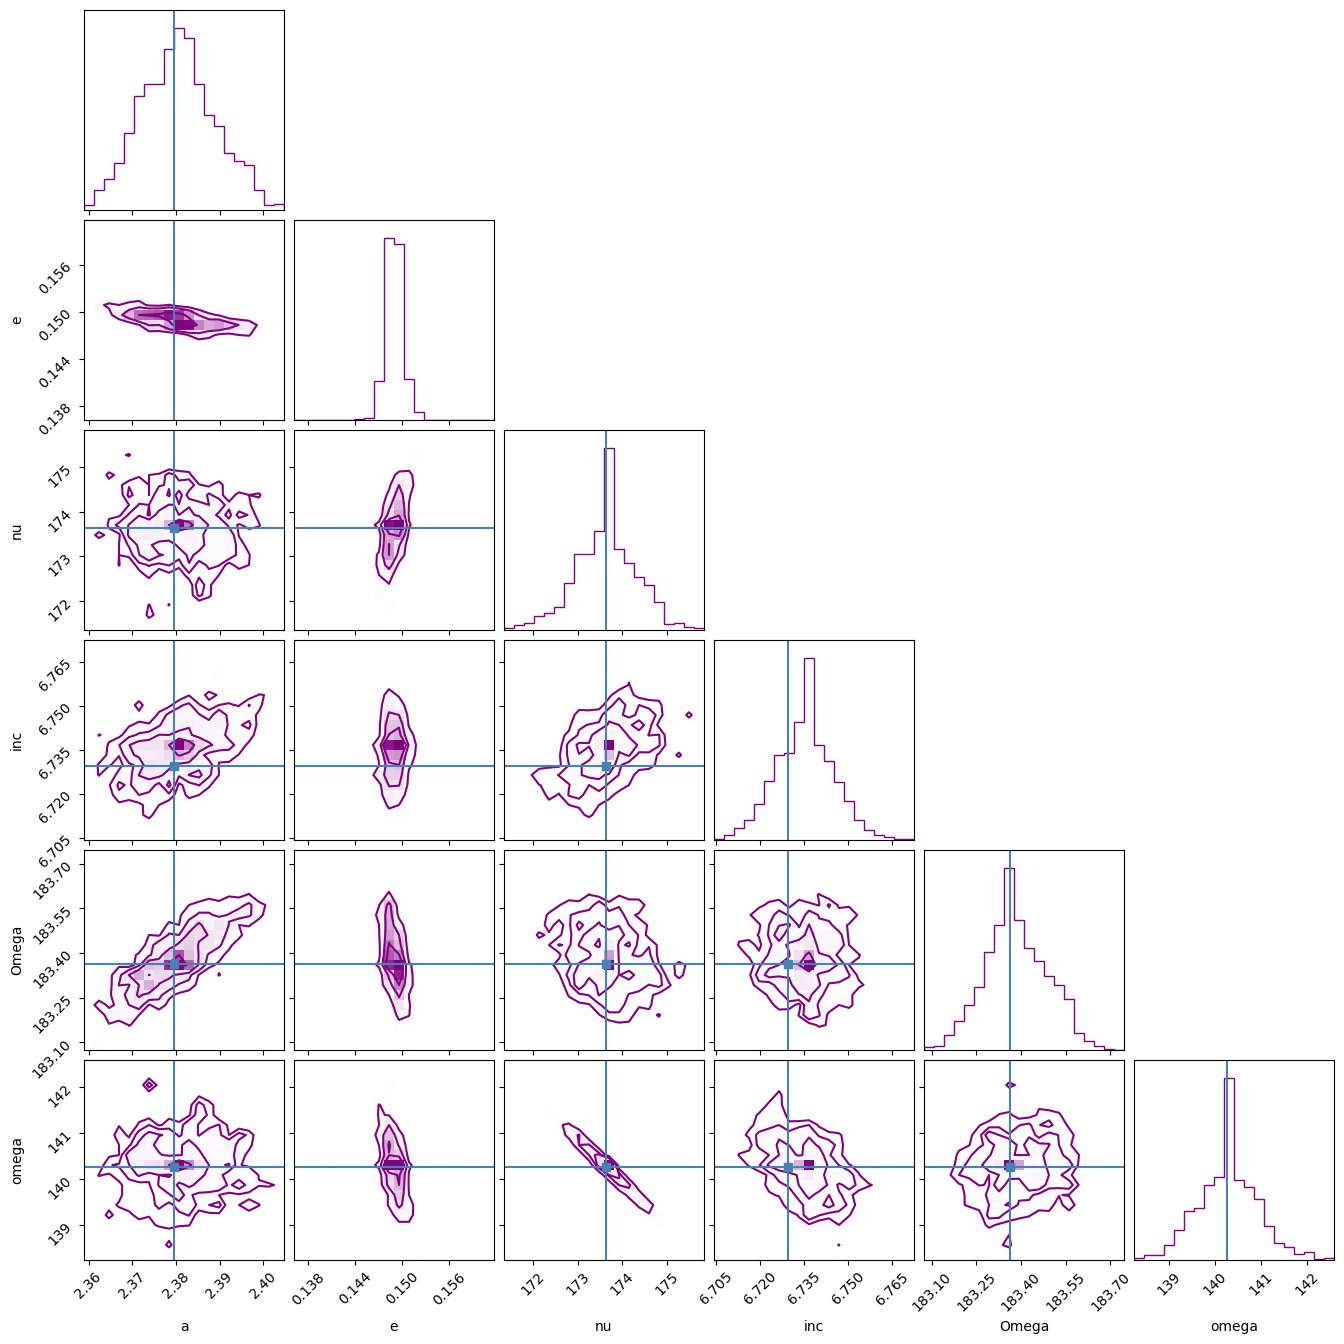

In [30]:
samples = sampler.get_chain(flat=True, thin=5)

fig = corner(
    samples,
    labels=["a", "e", "nu", "inc", "Omega", "omega"],
    truths=x0[0],
    color="purple",
    plot_datapoints=False,
    range=jnp.repeat(0.999, 6),
)